In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
load_dotenv()

True

In [9]:
class BatsmanState(TypedDict):
    runs : int
    balls : int 
    fours : int
    sixes : int

    strike_rate : float
    balls_per_boundary : float
    boundary_percent : float
    summary : str


During parallel workflows we need to return partial state ie in the form dictionary instead of complete state else it will return error as the value that are not updated langgraph will think that all state values are updated and can not decide which value to consider final so pass only updated values (partial state)

In [17]:
def calculate_strike_rate(state : BatsmanState):
    sr = (state['runs'] / state['balls'])*100
    return {'strike_rate' : sr}

def calculate_balls_per_boundary(state : BatsmanState):
    bpb = state['balls'] / (state['fours'] + state['sixes'])
    return {'balls_per_boundary' : bpb}
    
def calculate_boundary_percent(state : BatsmanState):
    bp = (((state['fours'] * 4 ) + (state['sixes'] * 6)) / state['runs'])*100
    return {'boundary_percent' : bp}
    

def summary(state: BatsmanState):
    summary = f"""
        Strike Rate - {state['strike_rate']} \n
        Balls per Boundary - {state['balls_per_boundary']} \n
        Boundary Percent - {state['boundary_percent']} \n
    """
    state['summary'] = summary
    return state


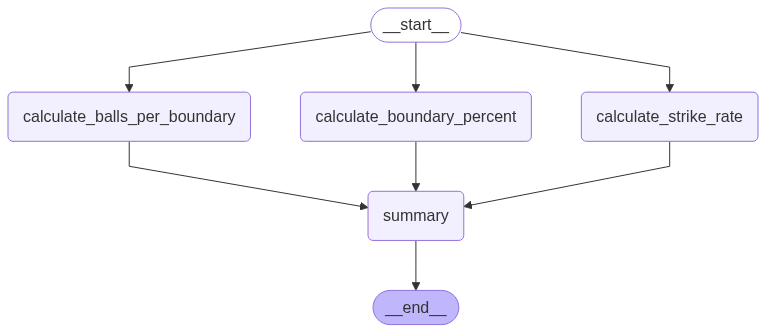

In [18]:
graph = StateGraph(BatsmanState)

graph.add_node('calculate_strike_rate', calculate_strike_rate)
graph.add_node('calculate_balls_per_boundary', calculate_balls_per_boundary)
graph.add_node('calculate_boundary_percent', calculate_boundary_percent)
graph.add_node('summary', summary)

graph.add_edge(START, "calculate_strike_rate")
graph.add_edge(START, "calculate_balls_per_boundary")
graph.add_edge(START, "calculate_boundary_percent")

graph.add_edge("calculate_strike_rate", "summary")
graph.add_edge("calculate_balls_per_boundary", "summary")
graph.add_edge("calculate_boundary_percent", "summary")

graph.add_edge("summary" , END)

workflow = graph.compile()
workflow

In [19]:
initial_state = {
    'runs': 100,
    'balls' : 50,
    'fours' : 6,
    'sixes' : 4
}

final_state = workflow.invoke(initial_state)


In [20]:
print(final_state['summary'])


        Strike Rate - 200.0 

        Balls per Boundary - 5.0 

        Boundary Percent - 48.0 

    
